# Yeni yöntem

In [1]:
import tensorflow as tf
import torch

import numpy as np 
import pandas as pd 
from matplotlib import image
from matplotlib import pyplot as plt
from tensorflow import keras
import os
import time
import datetime
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

In [2]:
batch_size = 64
img_size = 128

master_dir = 'val_256/train_samples/*.jpg'


In [3]:
def Load(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    return image

def GrayScale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

def resize(image, height, width):
    input_image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

@tf.function
def jitter(real_image, height, width):
    real_image = resize(real_image, height, width)
    return real_image

def normalize( real_image):
    real_image = (real_image / 255)
    return real_image

def Load_image_train(image):
    real_image = Load(image)
    real_image = jitter(real_image, img_size, img_size)
    real_image = normalize(real_image)
    input_image = GrayScale(real_image) 
    return input_image, real_image

In [4]:
train_dataset = tf.data.Dataset.list_files(master_dir)
train_dataset = train_dataset.map(Load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(400)
train_dataset = train_dataset.batch(batch_size)

In [5]:
def get_generator_model():
    
    inputs = tf.keras.layers.Input( shape=(img_size, img_size, 1))
    
    conv1  = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=1, padding='same' )(inputs)
    conv1  = tf.keras.layers.LeakyReLU()(conv1)
    
    conv2  = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=2, padding='same' )(conv1)
    conv2  = tf.keras.layers.LeakyReLU()(conv2)
    
    conv3  = tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=2, padding='same' )(conv2)
    conv3  = tf.keras.layers.LeakyReLU()(conv3)
    
    conv4  = tf.keras.layers.Conv2D(filters=256, kernel_size=(4,4), strides=2, padding='same' )(conv3)
    conv4  = tf.keras.layers.LeakyReLU()(conv4)
    
    conv5  = tf.keras.layers.Conv2D(filters=512, kernel_size=(4,4), strides=2, padding='same' )(conv4)
    conv5  = tf.keras.layers.LeakyReLU()(conv5)
    
    conv6  = tf.keras.layers.Conv2D(filters=512, kernel_size=(4,4), strides=2, padding='same' )(conv5)
    conv6  = tf.keras.layers.LeakyReLU()(conv6)
    
    conv7  = tf.keras.layers.Conv2D(filters=512, kernel_size=(4,4), strides=2, padding='same' )(conv6)
    conv7  = tf.keras.layers.LeakyReLU()(conv7)
    
    conv8  = tf.keras.layers.Conv2D(filters=512, kernel_size=(4,4), strides=2, padding='same' )(conv7)
    conv8  = tf.keras.layers.LeakyReLU()(conv8)
    
    
    deconv8 = tf.keras.layers.Conv2DTranspose(filters=512 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( conv8 )
    deconv8 = tf.keras.layers.Concatenate() ([conv7, deconv8])
    
    deconv7 = tf.keras.layers.Conv2DTranspose(filters=512 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( deconv8 )
    deconv7 = tf.keras.layers.Concatenate() ([conv6, deconv7])
    
    deconv6 = tf.keras.layers.Conv2DTranspose(filters=512 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( deconv7 )
    deconv6 = tf.keras.layers.Concatenate() ([conv5, deconv6])
    
    deconv5 = tf.keras.layers.Conv2DTranspose(filters=256 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( deconv6 )
    deconv5 = tf.keras.layers.Concatenate() ([conv4, deconv5])
    
    deconv4 = tf.keras.layers.Conv2DTranspose(filters=128 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( deconv5 )
    deconv4 = tf.keras.layers.Concatenate() ([conv3, deconv4])
    
    deconv3 = tf.keras.layers.Conv2DTranspose(filters=64 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( deconv4 )
    deconv3 = tf.keras.layers.Concatenate() ([conv2, deconv3])
    
    deconv2 = tf.keras.layers.Conv2DTranspose(filters=64 , kernel_size=( 4 , 4 ) , strides=2 , padding='same', activation='relu' )( deconv3 )
    deconv2 = tf.keras.layers.Concatenate() ([conv1, deconv2])
    
    
    deconv1 = tf.keras.layers.Conv2D(filters=3, kernel_size=( 1 , 1 ) , padding='same', strides=1, activation='tanh') (deconv2)
    
    model = tf.keras.models.Model( inputs, deconv1 )
    
    return model     

In [6]:
generator = get_generator_model()

In [7]:
def get_discriminator_model():
    layers = [
            tf.keras.layers.Conv2D( filters = 64, kernel_size=( 4 , 4 ), strides=2, activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D( filters = 128, kernel_size=( 4 , 4 ), strides=2, activation='relu', padding='same' ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D( filters = 256, kernel_size=( 4 , 4 ), strides=2, activation='relu', padding='same' ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D( filters = 512, kernel_size=( 4 , 4 ), strides=1, activation='relu', padding='same' ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D( filters = 1, kernel_size=( 4 , 4 ), strides=1, padding='same' ),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense( 512, activation='relu'  )  ,
            tf.keras.layers.Dense( 128 , activation='relu' ) ,
            tf.keras.layers.Dense( 16 , activation='relu' ) ,
            tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
        ]
    
    model = tf.keras.models.Sequential( layers )
    return model

In [8]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=32)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [9]:
discriminator = get_discriminator_model()

/Users/hbasriuzun/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

In [12]:
generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

In [13]:
sample_image = tf.io.read_file('val_256/train_samples/Places365_val_00000002.jpg')
sample_image = tf.io.decode_jpeg(sample_image, channels=3)
sample_image = tf.cast(sample_image, tf.float32)
sample_image = tf.image.resize(sample_image, [img_size, img_size], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
real_sample_image = sample_image
sample_image =  tf.image.rgb_to_grayscale(sample_image)
print(sample_image.shape)

(128, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


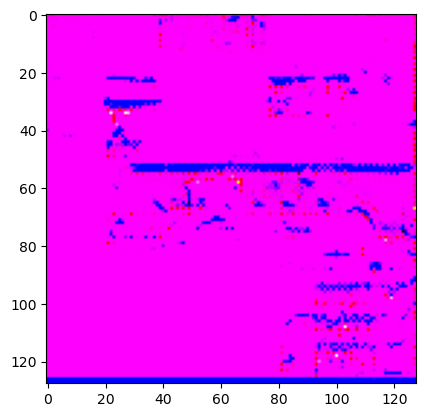

In [14]:
gen_output = generator(sample_image[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0])

In [15]:
checkpoint_path = "./"
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir="logs/"
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
@tf.function
def train_step( input_x , real_y, e ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator( input_x , training=True)
     
        real_output = discriminator( real_y, training=True)

        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss( generated_images , real_y )
        
        disc_loss = discriminator_loss( real_output, generated_output )
        
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('Generator Loss : ', gen_loss, step=e)
        tf.summary.scalar('Dicriminator Loss : ', disc_loss, step=e)
    
    generator.call

## TRAIN

In [18]:
for element in train_dataset.take(1):
    print(element)


In [ ]:
#num_epochs = 20

#for e in range( num_epochs ):
 #   start_time = time.time()
  #  for (x,y) in train_dataset:
   #     train_step( x , y , e)
    #if e%10 == 0:
     #   print('Epoch ', e,' Elapsed ', round(time.time()-start_time,0), 'seconds')

In [ ]:
validation_dir = '../input/places365/val_256/valid_samples/*.jpg'
validation_dataset = tf.data.Dataset.list_files(validation_dir)
validation_dataset = validation_dataset.map(Load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(400)
validation_dataset = validation_dataset.batch(batch_size)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ../input/places365/val_256/valid_samples/*.jpg'

In [ ]:
def Pixelwise_Accuracy(real_image, fake_image):
    diffL = tf.abs(tf.round(real_image[..., 0]) - tf.round(fake_image[..., 0]))
    diffA = tf.abs(tf.round(real_image[..., 1]) - tf.round(fake_image[..., 1]))
    diffB = tf.abs(tf.round(real_image[..., 2]) - tf.round(fake_image[..., 2]))
    predL = tf.cast(tf.less_equal(diffL, real_image[..., 0]), tf.float64)
    predA = tf.cast(tf.less_equal(diffA, real_image[..., 1]), tf.float64)
    predB = tf.cast(tf.less_equal(diffB, real_image[..., 2]), tf.float64)
    pred = predL * predA * predB
    return tf.reduce_mean(pred)

def Loss_Func(dataset):
    disc_loss, gen_loss, n = 0, 0, 0
    for ( x, y ) in dataset:
        fake_output = generator(x)
        disc_loss = discriminator_loss(y, fake_output)
        gen_loss = generator_loss(fake_output , y)
        n += 1
    print('Generator Loss : ', end='')
    tf.print(gen_loss)
    print('Discriminator Loss : ', end='')
    tf.print(disc_loss)

def Accuracy(dataset):
    global grayscale
    global original
    global fake
    acc = 0
    for ( x, y ) in dataset:
        grayscale = x
        original = y
        fake = generator(x)
        break
    for i in range(len(y)):
        acc += Pixelwise_Accuracy(original[i], fake[i] )
    return acc/batch_size

In [ ]:
accuracy = Accuracy(validation_dataset)
print("Generator Accuracy : ", end="")
tf.print(accuracy)

NameError: name 'validation_dataset' is not defined

In [ ]:
Loss_Func(validation_dataset)

NameError: name 'validation_dataset' is not defined

NameError: name 'grayscale' is not defined

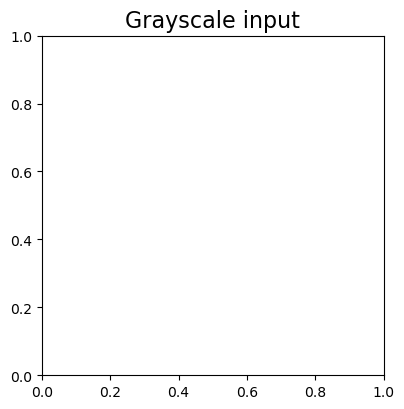

In [ ]:
for i in range(batch_size):
    plt.figure(figsize=(15, 15))
    or_image = plt.subplot(3,3,1)
    or_image.set_title('Grayscale input', fontsize=16)
    plt.imshow((grayscale[i].numpy()).reshape((128, 128)), cmap='gray')

    in_image = plt.subplot(3,3,2)
    image = Image.fromarray( ((fake[i].numpy())*255).astype('uint8') ).resize((1024, 1024))
    image = np.asarray(image)
    in_image.set_title('Colorized output', fontsize=16)
    plt.imshow( image )

    ou_image = plt.subplot(3,3,3)
    image = Image.fromarray( ((original[i].numpy())*255).astype('uint8') ).resize((1024, 1024)) 
    image = np.asarray(image)
    ou_image.set_title('Ground truth', fontsize=16)
    plt.imshow(image)
    plt.show()

In [ ]:
import tensorflow as tf

# .keras uzantılı modeli yükleme
model = tf.keras.models.load_model('generator_model.keras')


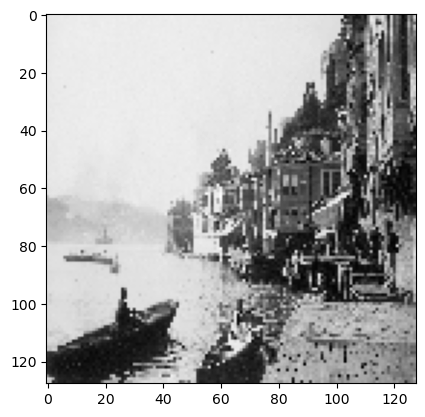

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


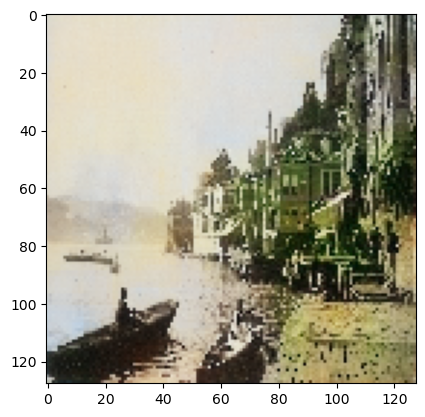

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Görüntü dosyasını yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)  # Gri tonlamalı hale getirme
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalizasyon
    return image

# Görüntü dosyasını yükleme
image_path = 'konstantiniyyeden-istanbula-1.jpg'
target_size = (128, 128)  # Modelinizin giriş boyutuna göre ayarlayın

# Görüntüyü yükleme ve ön işleme
input_image = load_and_preprocess_image(image_path, target_size)
input_image = tf.expand_dims(input_image, axis=0)  # Batch dimension ekleme

# Görüntüyü görselleştirme
plt.imshow(input_image[0], cmap='gray')
plt.show()

# Modeli yükleme
model = tf.keras.models.load_model('generator_model.keras')

# Modeli kullanarak tahmin yapma
predicted_image = model.predict(input_image)

# Sonucu görselleştirme
plt.imshow(predicted_image[0])
plt.show()


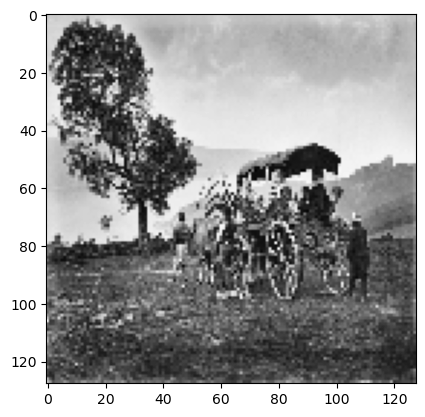

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


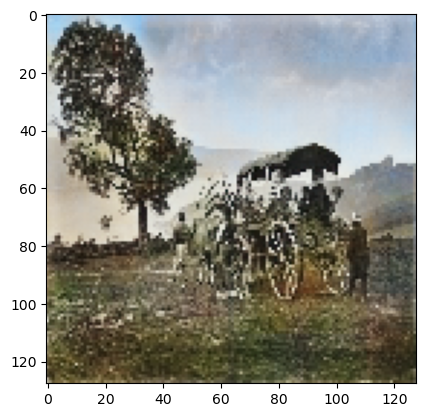

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Görüntü dosyasını yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)  # Gri tonlamalı hale getirme
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalizasyon
    return image

# Görüntü dosyasını yükleme
image_path = 'pascal-sabah.jpg'
target_size = (128, 128)  # Modelinizin giriş boyutuna göre ayarlayın

# Görüntüyü yükleme ve ön işleme
input_image = load_and_preprocess_image(image_path, target_size)
input_image = tf.expand_dims(input_image, axis=0)  # Batch dimension ekleme

# Görüntüyü görselleştirme
plt.imshow(input_image[0], cmap='gray')
plt.show()

# Modeli yükleme
model = tf.keras.models.load_model('generator_model.keras')

# Modeli kullanarak tahmin yapma
predicted_image = model.predict(input_image)

# Sonucu görselleştirme
plt.imshow(predicted_image[0])
plt.show()


Directory exists: saved_model_directory
Contents of the directory:
['variables', 'saved_model.pb', 'assets']


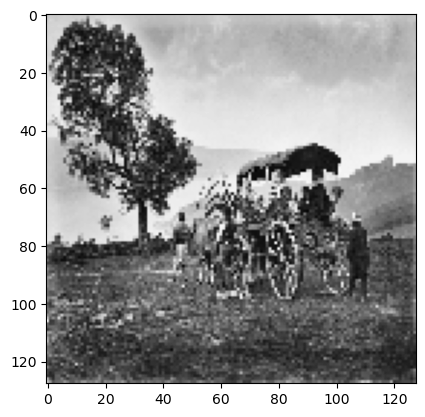

Structured outputs of the model:
conv2d_8: TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='conv2d_8')
Predictions keys:
conv2d_8


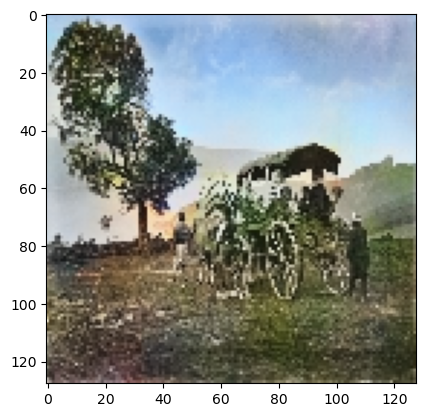

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Modelin bulunduğu dizini belirleme
model_dir = 'saved_model_directory'

# Modelin dosya yapısını kontrol etme
if os.path.exists(model_dir):
    print(f"Directory exists: {model_dir}")
    print("Contents of the directory:")
    print(os.listdir(model_dir))
else:
    print(f"Directory does not exist: {model_dir}")

# Modeli yükleme
model = tf.saved_model.load(model_dir)

# Örnek bir görüntü dosyasını yükleme ve işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.image.rgb_to_grayscale(image)  # Gri tonlamalı hale getirme
    image = image / 255.0  # Normalizasyon
    return image

# Görüntü dosyasını yükleme
image_path = 'pascal-sabah.jpg'
target_size = (128, 128)  # Modelinizin giriş boyutuna göre ayarlayın

# Görüntüyü yükleme ve ön işleme
input_image = load_and_preprocess_image(image_path, target_size)
input_image = tf.expand_dims(input_image, axis=0)  # Batch dimension ekleme

# Görüntüyü görselleştirme
plt.imshow(input_image[0], cmap='gray')
plt.show()

# Modelin imza fonksiyonunu alma
infer = model.signatures["serving_default"]

# İmza fonksiyonunun çıktısını kontrol etme
print("Structured outputs of the model:")
for key, value in infer.structured_outputs.items():
    print(f"{key}: {value}")

# Tahmin yapma
predictions = infer(tf.constant(input_image))

# Çıktının anahtarlarını kontrol etme ve sonucu görselleştirme
print("Predictions keys:")
for key in predictions.keys():
    print(key)

# Doğru anahtarı belirleyip görselleştirme
output_key = list(predictions.keys())[0]  # İlk anahtarı alalım, doğru anahtar bu olabilir
plt.imshow(predictions[output_key][0])
plt.show()


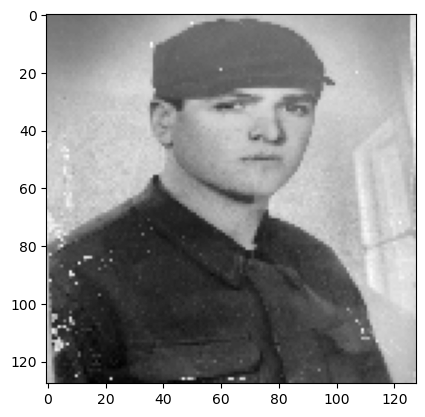

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


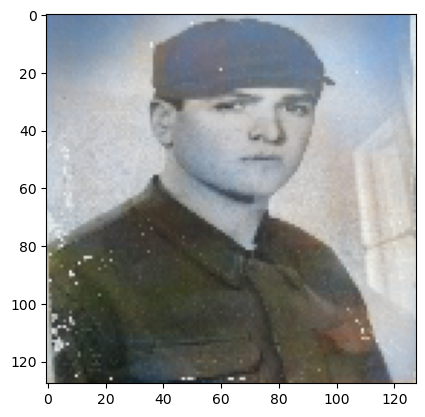

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Görüntü dosyasını yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)  # Gri tonlamalı hale getirme
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalizasyon
    return image

# Görüntü dosyasını yükleme
image_path = 'basri_dede.jpg'
target_size = (128, 128)  # Modelinizin giriş boyutuna göre ayarlayın

# Görüntüyü yükleme ve ön işleme
input_image = load_and_preprocess_image(image_path, target_size)
input_image = tf.expand_dims(input_image, axis=0)  # Batch dimension ekleme

# Görüntüyü görselleştirme
plt.imshow(input_image[0], cmap='gray')
plt.show()

# Modeli yükleme
model = tf.keras.models.load_model('generator_model.keras')

# Modeli kullanarak tahmin yapma
predicted_image = model.predict(input_image)

# Sonucu görselleştirme
plt.imshow(predicted_image[0])
plt.show()


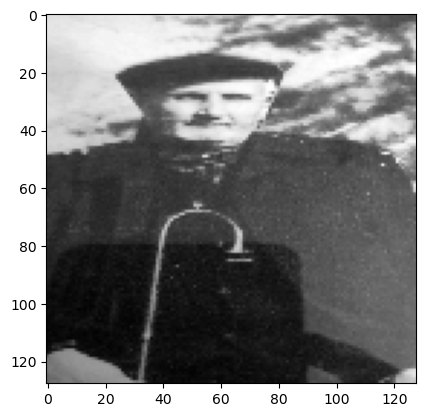

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


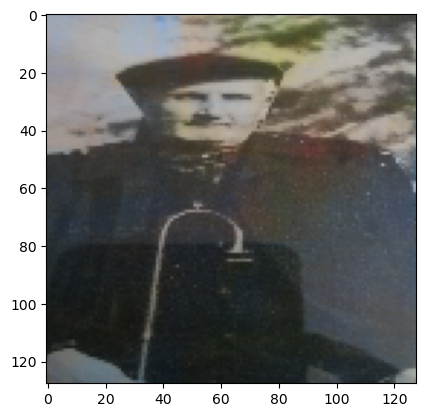

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Görüntü dosyasını yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)  # Gri tonlamalı hale getirme
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalizasyon
    return image

# Görüntü dosyasını yükleme
image_path = 'dede2.jpg'
target_size = (128, 128)  # Modelinizin giriş boyutuna göre ayarlayın

# Görüntüyü yükleme ve ön işleme
input_image = load_and_preprocess_image(image_path, target_size)
input_image = tf.expand_dims(input_image, axis=0)  # Batch dimension ekleme

# Görüntüyü görselleştirme
plt.imshow(input_image[0], cmap='gray')
plt.show()

# Modeli yükleme
model = tf.keras.models.load_model('generator_model.keras')

# Modeli kullanarak tahmin yapma
predicted_image = model.predict(input_image)

# Sonucu görselleştirme
plt.imshow(predicted_image[0])
plt.show()


Directory exists: saved_model_directory
Contents of the directory:
['variables', 'c1b7bfa0-f1b7-4205-bbd5-777b8e2ef414.png', 'saved_model.pb', 'assets']


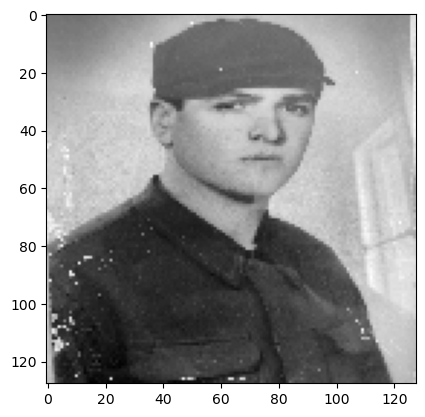

Structured outputs of the model:
conv2d_8: TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='conv2d_8')
Predictions keys:
conv2d_8


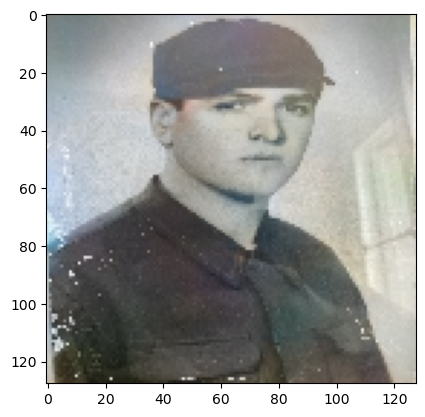

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Modelin bulunduğu dizini belirleme
model_dir = 'saved_model_directory'

# Modelin dosya yapısını kontrol etme
if os.path.exists(model_dir):
    print(f"Directory exists: {model_dir}")
    print("Contents of the directory:")
    print(os.listdir(model_dir))
else:
    print(f"Directory does not exist: {model_dir}")

# Modeli yükleme
model = tf.saved_model.load(model_dir)

# Örnek bir görüntü dosyasını yükleme ve işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.image.rgb_to_grayscale(image)  # Gri tonlamalı hale getirme
    image = image / 255.0  # Normalizasyon
    return image

# Görüntü dosyasını yükleme
image_path = 'basri_dede.jpg'
target_size = (128, 128)  # Modelinizin giriş boyutuna göre ayarlayın

# Görüntüyü yükleme ve ön işleme
input_image = load_and_preprocess_image(image_path, target_size)
input_image = tf.expand_dims(input_image, axis=0)  # Batch dimension ekleme

# Görüntüyü görselleştirme
plt.imshow(input_image[0], cmap='gray')
plt.show()

# Modelin imza fonksiyonunu alma
infer = model.signatures["serving_default"]

# İmza fonksiyonunun çıktısını kontrol etme
print("Structured outputs of the model:")
for key, value in infer.structured_outputs.items():
    print(f"{key}: {value}")

# Tahmin yapma
predictions = infer(tf.constant(input_image))

# Çıktının anahtarlarını kontrol etme ve sonucu görselleştirme
print("Predictions keys:")
for key in predictions.keys():
    print(key)

# Doğru anahtarı belirleyip görselleştirme
output_key = list(predictions.keys())[0]  # İlk anahtarı alalım, doğru anahtar bu olabilir
plt.imshow(predictions[output_key][0])
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Model dosyalarını indir
prototxt = "https://raw.githubusercontent.com/richzhang/colorization/master/models/colorization_deploy_v2.prototxt"
caffemodel = "http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel"
pts_in_hull = "https://raw.githubusercontent.com/richzhang/colorization/master/resources/pts_in_hull.npy"

!wget -O colorization_deploy_v2.prototxt {prototxt}
!wget -O colorization_release_v2.caffemodel {caffemodel}
!wget -O pts_in_hull.npy {pts_in_hull}

# Modeli yükle
net = cv2.dnn.readNetFromCaffe('colorization_deploy_v2.prototxt', 'colorization_release_v2.caffemodel')
pts = np.load('pts_in_hull.npy')

# Küme merkezlerini 1x1'e göre adapte et
class8 = net.getLayerId('class8_ab')
conv8 = net.getLayerId('conv8_313_rh')

pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype(np.float32)]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, np.float32)]


ModuleNotFoundError: No module named 'cv2'